# EXAMEN 2

## EJERCICIO 1

Predice las ventas mensuales de una cadena de tiendas minoristas para los próximos dos meses, teniendo en cuenta los 12 últimos meses anteriores.

Pasos a seguir:

* Preparación de Datos:
    * Cargar los datos históricos de ventas (retail_sales.csv).
    * Gráfica de las ventas a lo largo del tiempo.
    * Normalizar los datos (normaliza y desnormaliza los datos manualmente)
    * Dividir los datos en conjuntos de entrenamiento, validación y pruebas.
    * Crear secuencias de datos de longitud fija para entrenar la red.

* Construcción del Modelo:   
    * Utilizar una Red Neuronal Recurrente (RNN) con celdas GRU (Gated Recurrent Unit) (mínimo 2 capas)
    * Añadir una capa densa al final para la predicción de las ventas.

* Entrenamiento:
    * Configurar el modelo con una función de pérdida MSE (Mean Squared Error), un optimizador Adam y la métrica del error absoluto medio.
    * Utiliza detección temprana

* Evaluación y Predicción:
    * Evaluar el modelo en el conjunto de prueba para verificar su rendimiento.
    * Realizar predicciones de las ventas para los próximos 2 meses (abril y mayo)
   
    Nota: si te fijas en los datos es muy fácil predecir el resultado para abril y mayo comprueba que los resultados que obtienes concuerdan con lo esperado para estar seguro de que está bien hecho.

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

In [5]:
path = Path("retail_sales.csv")
df = pd.read_csv(path)
df

,Month,Sales
0,2014-01-01,1000
1,2014-02-01,2000
2,2014-03-01,3000
3,2014-04-01,4000
4,2014-05-01,1000
...,...,...
118,2023-11-01,3000
119,2023-12-01,4000
120,2024-01-01,1000
121,2024-02-01,2000


In [6]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index("Month", inplace=True)
df

,Sales
Month,
2014-01-01,1000
2014-02-01,2000
2014-03-01,3000
2014-04-01,4000
2014-05-01,1000
...,...
2023-11-01,3000
2023-12-01,4000
2024-01-01,1000


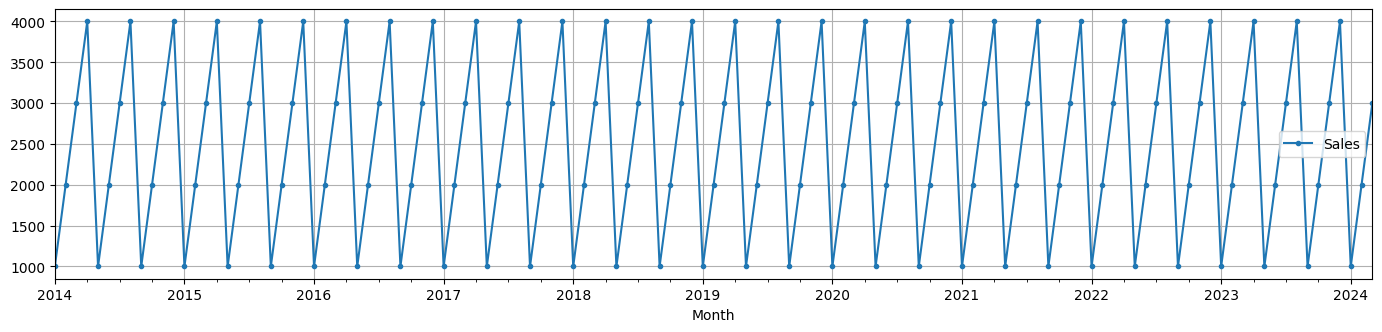

In [7]:
df.plot(grid=True, marker=".", figsize=(17, 3.5))
plt.show()

<Axes: xlabel='Month'>

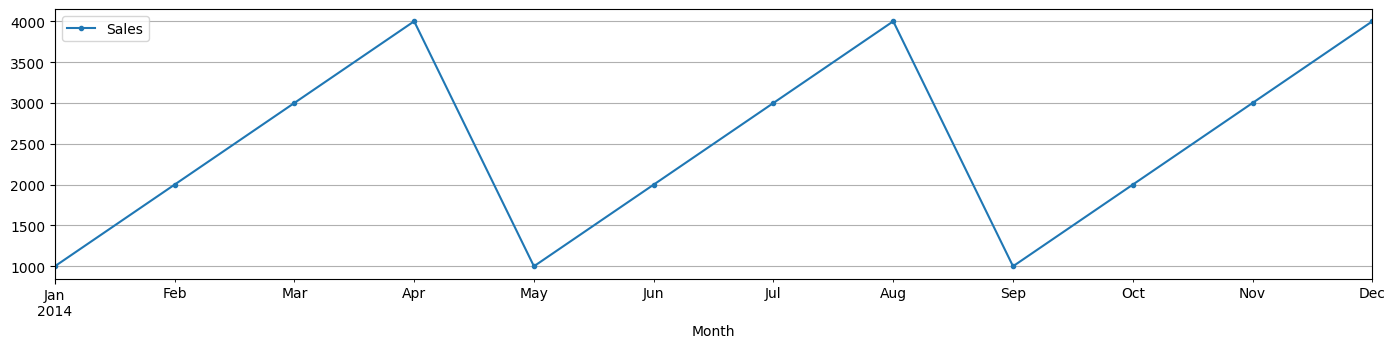

In [8]:
df["2014-1":"2014-12"].plot(grid=True, marker=".", figsize=(17, 3.5))

In [9]:
media = df.mean()
std = df.std()

df2 = (df - media) / std
df2.max()

Sales    1.351522
dtype: float64

In [10]:
df2.min()

Sales   -1.329723
dtype: float64

In [11]:
train = df2["2014-01":"2019-12"]
valid = df2["2020-01":"2022-12"]
test = df2["2021-01":]

valid

,Sales
Month,
2020-01-01,-1.329723
2020-02-01,-0.435975
2020-03-01,0.457774
2020-04-01,1.351522
2020-05-01,-1.329723
2020-06-01,-0.435975
2020-07-01,0.457774
2020-08-01,1.351522
2020-09-01,-1.329723


In [12]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=24, ahead=12, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [13]:
seq2seq_train = to_seq2seq_dataset(train.to_numpy(dtype="float32"), shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(valid.to_numpy(dtype="float32"))
seq2seq_test = to_seq2seq_dataset(test.to_numpy(dtype="float32"))


In [14]:
tf.random.set_seed(42)
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.GRU(132, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.GRU(132, return_sequences=True),
    tf.keras.layers.Dense(12)
])

In [15]:
def fit_and_evaluate(model, train_set, valid_set, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping( monitor="val_mse", patience=50, restore_best_weights=True)
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    _, valid_mse = model.evaluate(valid_set)
    return valid_mse

In [16]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Epoch 1/500



2/2 [==============================] - 4s 817ms/step - loss: 0.9942 - mse: 0.9942 - val_loss: 0.9738 - val_mse: 0.9738
Epoch 2/500
2/2 [==============================] - 0s 45ms/step - loss: 0.9728 - mse: 0.9728 - val_loss: 0.9529 - val_mse: 0.9529
Epoch 3/500
2/2 [==============================] - 0s 51ms/step - loss: 0.9520 - mse: 0.9520 - val_loss: 0.9292 - val_mse: 0.9292
Epoch 4/500
2/2 [==============================] - 0s 50ms/step - loss: 0.9282 - mse: 0.9282 - val_loss: 0.9015 - val_mse: 0.9015
Epoch 5/500
2/2 [==============================] - 0s 49ms/step - loss: 0.9003 - mse: 0.9003 - val_loss: 0.8684 - val_mse: 0.8684
Epoch 6/500
2/2 [==============================] - 0s 49ms/step - loss: 0.8666 - mse: 0.8666 - val_loss: 0.8281 - val_mse: 0.8281
Epoch 7/500
2/2 [==============================] - 0s 52ms/step - loss: 0.8253 - mse: 0.8253 - val_loss: 0.7783 - val_mse: 0.7783
Epoch 8/500
2/2 [==============================] - 0s 53ms/step - loss: 0.7740 - mse: 0.7740 - val_lo

0.003110200399532914

In [17]:
test_loss, test_mse = seq2seq_model.evaluate(seq2seq_test)
print(f"Test mse: {test_mse}")

1/1 [==============================] - 0s 67ms/step - loss: 0.0095 - mse: 0.0095
Test mse: 0.009530186653137207


In [49]:
# def to_seq2seq_dataset2(series, seq_length=24, ahead=2, target_col=1,
#                        batch_size=32, shuffle=False, seed=None):
#     ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
#     ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:]))
#     if shuffle:
#         ds = ds.shuffle(8 * batch_size, seed=seed)
#     return ds.batch(batch_size)

data = {'Month': ['2024-04-01', '2024-05-01'], 'Sales': [0.,0.]}

df_predict = pd.DataFrame(data, columns=['Month',"Sales"])
df_predict['Month'] = pd.to_datetime(df_predict['Month'])
df_predict.set_index("Month", inplace=True)

df_predict


,Sales
Month,
2024-04-01,0.0
2024-05-01,0.0


In [50]:
# seq2seq_predict = to_seq2seq_dataset(valid.to_numpy(dtype="float32"))
X = df_predict.to_numpy(dtype="float32")[np.newaxis, :12]
predictions = seq2seq_model.predict(X)[0, -1]
predictions

1/1 [==============================] - 0s 15ms/step


array([ 1.664387  , -0.7671667 , -0.8804724 ,  0.02162167,  1.6827631 ,
       -0.7182977 , -0.8978549 ,  0.0208199 ,  1.6014649 , -0.79751307,
       -0.9246686 ,  0.06520569], dtype=float32)

In [56]:
# predictions2 = predictions(lambda x: (x + x.mean()) * x.std(), axis=0)
predictions_desnormalizado = []
for pred in predictions:
    predictions_desnormalizado.append((pred * media) + std)
predictions_desnormalizado

[Sales    5259.553099
 dtype: float64,
 Sales   -789.677962
 dtype: float64,
 Sales   -1071.560553
 dtype: float64,
 Sales    1172.67353
 dtype: float64,
 Sales    5305.26928
 dtype: float64,
 Sales   -668.101539
 dtype: float64,
 Sales   -1114.804828
 dtype: float64,
 Sales    1170.678883
 dtype: float64,
 Sales    5103.015142
 dtype: float64,
 Sales   -865.173868
 dtype: float64,
 Sales   -1181.512046
 dtype: float64,
 Sales    1281.102074
 dtype: float64]

## EJERCICIO 2

Para este ejercicio, entrenaremos un modelo de Hugging Face ya preentrenado para una tarea de clasificación de sentimientos en español. Utilizaremos un modelo BERT en español como base.

Los datos de entrenamiento, validación, pruebas y los nuevos datos para hacer predicciones son los siguientes:

``````
# Datos de entrenamiento
datos_entrenamiento = [
    ("Me encanta esta película, es fantástica.", "positivo"),
    ("Esta es la mejor película del año.", "positivo"),
    ("Qué aburrida fue esta película.", "negativo"),
    ("Esta película no es lo que esperaba, pero de buena manera.", "positivo"),
    ("No creo que quiera ver esa película de nuevo.", "negativo"),
    ("No me gustó la película, fue terrible.", "negativo"),
    ("Me sentí decepcionado por la película.", "negativo"),
    ("Increíble, me encantó cada parte de la película.", "positivo"),
]

# Datos de validación
datos_validacion = [
    ("No me gustó mucho esta película.", "negativo"),
    ("La película estuvo genial, muy recomendada.", "positivo"),
]

# Datos de prueba
datos_prueba = [
    ("La película no fue lo que esperaba.", "negativo"),
    ("Me sorprendió gratamente esta película.", "positivo"),
]

# Nuevos datos para predicciones
nuevos_datos = [
    "Esta película es lo que esperaba.",
    "Quiero ver esa película de nuevo.",
]
``````

Los pasos a seguir son los siguientes:
* Carga el modelo BERT preentrenado y su tokenizador.
* Prepara los conjuntos de datos, validación y pruebas (tokenizar y crear el dataset de TensorFlow)
* Entrena el modelo con nuestros datos de entrenamiento.
* Evalúa el rendimiento del modelo con el conjunto de datos de prueba.
* Haz predicciones para los datos nuevos

Evidentemente los resultados van a ser muy malos porque no hay datos suficientes

In [ ]:
# Datos de entrenamiento
datos_entrenamiento = [
    ("Me encanta esta película, es fantástica.", "positivo"),
    ("Esta es la mejor película del año.", "positivo"),
    ("Qué aburrida fue esta película.", "negativo"),
    ("Esta película no es lo que esperaba, pero de buena manera.", "positivo"),
    ("No creo que quiera ver esa película de nuevo.", "negativo"),
    ("No me gustó la película, fue terrible.", "negativo"),
    ("Me sentí decepcionado por la película.", "negativo"),
    ("Increíble, me encantó cada parte de la película.", "positivo"),
]

# Datos de validación
datos_validacion = [
    ("No me gustó mucho esta película.", "negativo"),
    ("La película estuvo genial, muy recomendada.", "positivo"),
]

# Datos de prueba
datos_prueba = [
    ("La película no fue lo que esperaba.", "negativo"),
    ("Me sorprendió gratamente esta película.", "positivo"),
]

# Nuevos datos para predicciones
nuevos_datos = [
    "Esta película es lo que esperaba.",
    "Quiero ver esa película de nuevo.",
    "Me encanta esta película, es fantástica.",
]

def separar_datos(datos):
    X_set = []
    y_set = []
    for data in datos:
        x, y =  data
        X_set.append(x)
        y_set.append(y)
    return X_set,y_set

X_train, y_train = separar_datos(datos_entrenamiento)
X_valid, y_valid = separar_datos(datos_validacion)
X_test, y_test = separar_datos(datos_prueba)
y_train


['positivo',
 'positivo',
 'negativo',
 'positivo',
 'negativo',
 'negativo',
 'negativo',
 'positivo']

In [ ]:
# Load model directly
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import tensorflow as tf
import torch

def preprocess(x, y):
    tokenized = tokenizer(x, padding=True, return_tensors="tf").data
    if (y):
        y = tf.constant([1 if label == "positivo" else 0 for label in y])
    return tokenized, y

X_train, y_train = preprocess(X_train, y_train)
X_valid, y_valid = preprocess(X_valid, y_valid)
X_test, y_test = preprocess(X_test, y_test)

nuevos_datos2, _ = preprocess(nuevos_datos, None)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50)

Epoch 1/50
1/1 [==============================] - 44s 44s/step - loss: 0.6940 - accuracy: 0.3750 - val_loss: 0.7149 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 0.7171 - accuracy: 0.5000 - val_loss: 1.1414 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 1.1029 - accuracy: 0.5000 - val_loss: 1.3313 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 1.2007 - accuracy: 0.5000 - val_loss: 0.9162 - val_accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 0.9781 - accuracy: 0.5000 - val_loss: 0.7116 - val_accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 0.7433 - accuracy: 0.5000 - val_loss: 0.7022 - val_accuracy: 0.5000
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 0.7275 - accuracy: 0.6250 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 8/50
1/1 [=======================

In [ ]:
_, test_accuracy = model.evaluate(X_test, y_test)
print(f"test_accuracy: {test_accuracy}")

1/1 [==============================] - 3s 3s/step - loss: 0.6940 - accuracy: 0.5000
test_accuracy: 0.5


In [ ]:

predictions = model.predict(nuevos_datos2).logits
predicted_labels = tf.argmax(predictions, axis=1)
for i in range(len(predicted_labels.numpy())):
    pred = "positivo" if predicted_labels.numpy()[i] == 1 else "negativo"
    print(nuevos_datos[i]+": "+pred)

1/1 [==============================] - 0s 75ms/step
Esta película es lo que esperaba.: negativo
Quiero ver esa película de nuevo.: negativo
Me encanta esta película, es fantástica.: negativo


## EJERCICIO 3

El conjunto de datos cats_vs_dogs https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=es-419 es conjunto de imágenes de perros y gatos.

Tienes que entrenar un modelo de redes convolucional para que aprenda a clasificar entre perro y gato, pero no vamos a empezar de cero, vamos a usar alguna de las redes ya existentes: InceptionV3

Tienes que seguir los siguientes pasos
* Carga el conjunto de imágenes (entrenamiento, validación (coge los datos del conjunto de pruebas) y pruebas)
* Explora los datos: dimensiones, número de elementos, dibuja algunas imágenes con sus etiquetas...
* Prepara los datos: añad3 más elementos al conjunto de entrenamiento (rotando, trasladando... las imágenes actuales) y prepara los datos para el modelo
* Entrena un modelo para estos datos(usando: InceptionV3)
* Busa una imagen en Internet y haz una predicción

Puede usar take(10) a la hora de entrenar aunque los resultados sean malísimos, con el fin de que no pierdas tiempo. Usa pocos epoch y añade como comentarios que valores pondrías realmente.

In [1]:
import tensorflow_datasets as tfds

data, info = tfds.load('cats_vs_dogs', split=["train[70%:]", "train[:70%]"], with_info=True, as_supervised=True)
test, train = data
validation = test.take(int(len(test)/2))
test = test.skip(int(len(test)/2))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteIPR67Y/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [2]:
len(validation)

3489

In [3]:
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes


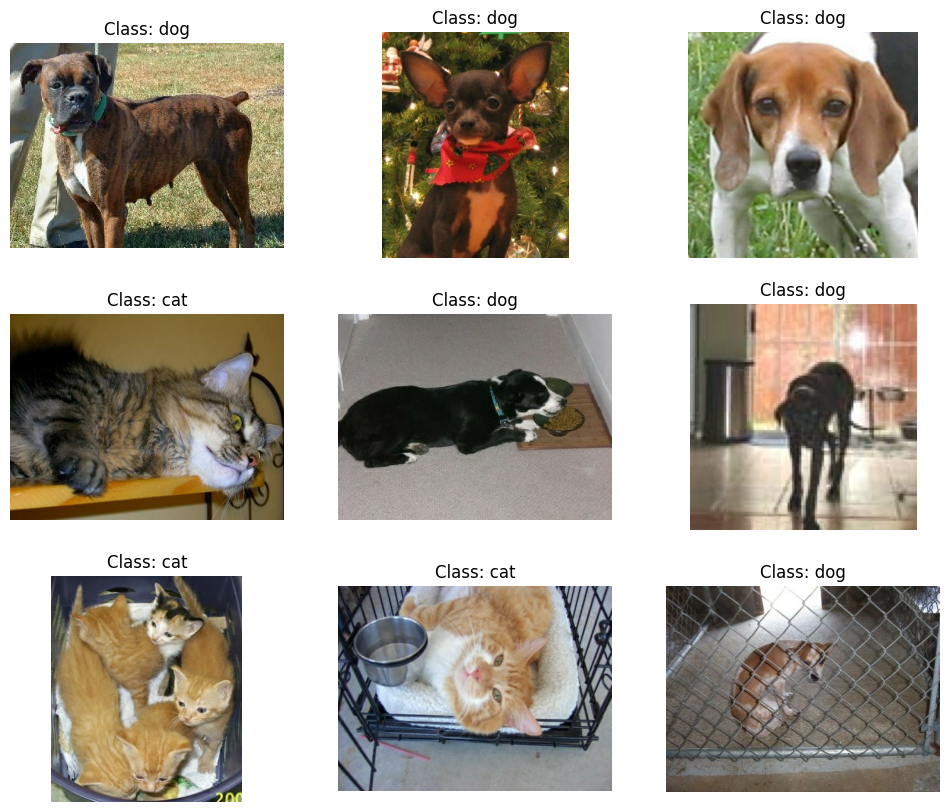

In [5]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(np.squeeze(image))
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [6]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.inception_v3.preprocess_input)
])
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=42)
])
train_new = train.map(lambda X, y: (data_augmentation(X), y))
train_new = train_new.map(lambda X, y: (preprocess(X), y))
train_set = train.map(lambda X, y: (preprocess(X), y))
train_set2 = train_set.concatenate(train_new).batch(batch_size).prefetch(1)

valid_set = validation.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [7]:
tf.random.set_seed(42)
base_model = tf.keras.applications.InceptionV3(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

87910968/87910968 [==============================] - 0s 0us/step


In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set2.take(10), validation_data=valid_set, epochs=3) #Cogeria todos los datos y haria 50 epoch para hacer la prueba inicial y ajuste los pesos de la capa Dense

Epoch 1/3
10/10 [==============================] - 24s 1s/step - loss: 1.5126 - accuracy: 0.8156 - val_loss: 0.6585 - val_accuracy: 0.9805
Epoch 2/3
10/10 [==============================] - 11s 1s/step - loss: 0.6485 - accuracy: 0.9688 - val_loss: 0.7392 - val_accuracy: 0.9828
Epoch 3/3
10/10 [==============================] - 9s 939ms/step - loss: 0.5482 - accuracy: 0.9875 - val_loss: 0.8296 - val_accuracy: 0.9819


In [10]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: batch_normalization_7  66: activation_22          99: max_pooling2d_2       
  1: conv2d                 34: batch_normalization_10 67: conv2d_20             100: mixed3                
  2: batch_normalization    35: batch_normalization_11 68: conv2d_23             101: conv2d_34             
  3: activation             36: activation_5           69: batch_normalization_20102: batch_normalization_34
  4: conv2d_1               37: activation_7           70: batch_normalization_23103: activation_34         
  5: batch_normalization_1  38: activation_10          71: activation_20         104: conv2d_35             
  6: activation_1           39: activation_11          72: activation_23         105: batch_normalization_35
  7: conv2d_2               40: mixed0                 73: average_pooling2d_2   106: activation_35         
  8: batch_normalization_2  41: conv2d_15              74: conv2d_19             107: conv2d_31             
  9: activation_2  

In [12]:
for layer in base_model.layers[107:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set2.take(10), validation_data=valid_set, epochs=6) #Cogeria todos los datos y haria 150 epoch (si el mejor accuracy estuviese en la ultima vuelta iria añadiendo epoch hasta que no pasase)

Epoch 1/6
10/10 [==============================] - 31s 1s/step - loss: 0.2474 - accuracy: 0.9062 - val_loss: 1420.5820 - val_accuracy: 0.5128
Epoch 2/6
10/10 [==============================] - 12s 1s/step - loss: 0.1737 - accuracy: 0.9656 - val_loss: 603.9778 - val_accuracy: 0.5331
Epoch 3/6
10/10 [==============================] - 12s 1s/step - loss: 0.0801 - accuracy: 0.9812 - val_loss: 280.2683 - val_accuracy: 0.5612
Epoch 4/6
10/10 [==============================] - 12s 1s/step - loss: 0.0957 - accuracy: 0.9906 - val_loss: 147.5732 - val_accuracy: 0.6139
Epoch 5/6
10/10 [==============================] - 12s 1s/step - loss: 0.0337 - accuracy: 0.9875 - val_loss: 53.8704 - val_accuracy: 0.6850
Epoch 6/6
10/10 [==============================] - 12s 1s/step - loss: 0.0112 - accuracy: 0.9969 - val_loss: 25.1955 - val_accuracy: 0.7584


/content


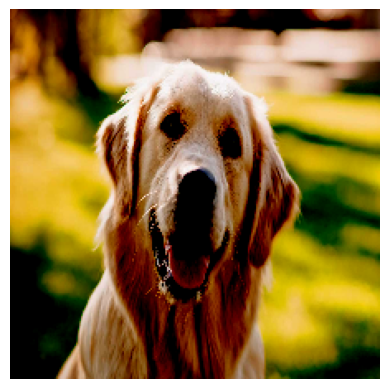

In [13]:
from keras.preprocessing import image
from keras.applications.resnet_v2 import preprocess_input, decode_predictions
import os

def cargar_y_preprocesar_imagen(ruta_imagen):
    img = image.load_img(ruta_imagen, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

HOME = os.getcwd()

%cd {HOME}
PATH = f"{HOME}/perro.jpg"
img1 = cargar_y_preprocesar_imagen(PATH)

plt.imshow(np.squeeze(img1))
plt.axis("off")

plt.show()

In [14]:
predicciones1 = model.predict(img1)
def decode_predictions(predictions, class_names):
    decoded = []
    for i in range(len(predictions)):
        idx = np.argmax(predictions[i])
        label = class_names[idx]
        decoded.append((idx, label))
    return decoded

decoded_predictions = decode_predictions(predicciones1, class_names)
print(decoded_predictions)


1/1 [==============================] - 2s 2s/step
[(1, 'dog')]


## EJERCICIO 4

Este ejercicio lo podéis hacer en Google Colab, tenéis que detectar cuantos coches cruzan la línea. Tenéis el video origen (trafico.mp4) así como el video de como quiero que quede (trafico_result.mp4)